In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import pickle
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

np.random.seed(42)
torch.manual_seed(42)

In [ ]:
class PopularityRecommender:
    def __init__(self):
        self.popular_items = None
    
    def fit(self, df):
        popularity = df.groupby('asin').agg({
            'overall': ['mean', 'count']
        }).reset_index()
        popularity.columns = ['asin', 'avg_rating', 'review_count']
        popularity['popularity_score'] = (
            popularity['avg_rating'] * np.log1p(popularity['review_count'])
        )
        self.popular_items = popularity.sort_values(
            'popularity_score', ascending=False
        )
        return self
    
    def recommend(self, user_id=None, n=10, exclude_items=None):
        recommendations = self.popular_items.head(n + (len(exclude_items) if exclude_items else 0))
        if exclude_items:
            recommendations = recommendations[~recommendations['asin'].isin(exclude_items)]
        return recommendations.head(n)['asin'].tolist()

class MatrixFactorizationSVD:
    def __init__(self, n_factors=50):
        self.n_factors = n_factors
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None
        self.user_bias = None
        self.item_bias = None
        self.user_to_idx = None
        self.item_to_idx = None
        self.idx_to_user = None
        self.idx_to_item = None
        self.sigma = None
    
    def predict(self, user_id, item_id):
        if user_id not in self.user_to_idx:
            return self.global_mean + self.item_bias.get(item_id, 0)
        if item_id not in self.item_to_idx:
            return self.global_mean + self.user_bias.get(user_id, 0)
        
        user_idx = self.user_to_idx[user_id]
        item_idx = self.item_to_idx[item_id]
        
        baseline = self.global_mean + \
                  self.user_bias.get(user_id, 0) + \
                  self.item_bias.get(item_id, 0)
        
        interaction = np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        prediction = baseline + interaction
        
        return np.clip(prediction, 1, 5)

class ContentBasedRecommender:
    def __init__(self, tfidf_matrix, product_mapping):
        self.tfidf_matrix = tfidf_matrix
        self.product_mapping = product_mapping
        self.knn_model = None
    
    def fit(self):
        from sklearn.neighbors import NearestNeighbors
        self.knn_model = NearestNeighbors(
            n_neighbors=20,
            metric='cosine',
            algorithm='brute'
        )
        self.knn_model.fit(self.tfidf_matrix)
        return self
    
    def recommend_similar(self, product_id, n=10):
        if product_id not in self.product_mapping:
            return []
        
        product_idx = self.product_mapping[product_id]
        product_vector = self.tfidf_matrix[product_idx]
        
        distances, indices = self.knn_model.kneighbors(
            product_vector, 
            n_neighbors=n+1
        )
        
        similar_indices = indices[0][1:]
        idx_to_product_local = {idx: pid for pid, idx in self.product_mapping.items()}
        similar_products = [idx_to_product_local[idx] for idx in similar_indices]
        
        return similar_products

In [6]:
train_df = pd.read_csv('data/processed/train_set.csv')
test_df = pd.read_csv('data/processed/test_set.csv')
df_complete = pd.read_csv('data/processed/features_complete.csv')

print(f"  Train: {len(train_df):,} records")
print(f"  Test: {len(test_df):,} records")
print(f"  Complete: {len(df_complete):,} records")

with open('models/popularity_model.pkl', 'rb') as f:
    popularity_model = pickle.load(f)

with open('models/svd_model.pkl', 'rb') as f:
    svd_model = pickle.load(f)

with open('models/content_model.pkl', 'rb') as f:
    content_model = pickle.load(f)

with open('models/product_tfidf_vectorizer.pkl', 'rb') as f:
    product_tfidf = pickle.load(f)
with open('models/product_tfidf_matrix.pkl', 'rb') as f:
    product_tfidf_matrix = pickle.load(f)
with open('models/product_to_idx.pkl', 'rb') as f:
    product_to_idx = pickle.load(f)

  Train: 1,089 records
  Test: 933 records
  Complete: 16,379 records


In [7]:
class WeightedEnsembleHybrid:
    """
    Hybrid recommender combining multiple models with learned weights
    """
    def __init__(self, svd_model, popularity_model, content_model, 
                 weights={'svd': 0.5, 'popularity': 0.3, 'content': 0.2}):
        self.svd_model = svd_model
        self.popularity_model = popularity_model
        self.content_model = content_model
        self.weights = weights
        
        total = sum(self.weights.values())
        self.weights = {k: v/total for k, v in self.weights.items()}
    
    def predict(self, user_id, item_id):
        """
        Predict rating using weighted ensemble
        """
        svd_pred = self.svd_model.predict(user_id, item_id)
        
        pop_items = self.popularity_model.popular_items
        if item_id in pop_items['asin'].values:
            pop_score = pop_items[pop_items['asin'] == item_id]['avg_rating'].values[0]
        else:
            pop_score = 3.0
        
        prediction = (
            self.weights['svd'] * svd_pred +
            self.weights['popularity'] * pop_score
        )
        
        return np.clip(prediction, 1, 5)
    
    def recommend(self, user_id, n=10, exclude_items=None):
        """
        Generate top N recommendations using hybrid approach
        """
        all_products = train_df['asin'].unique()
        
        user_items = set(train_df[train_df['reviewerID'] == user_id]['asin'])
        unseen_products = [p for p in all_products if p not in user_items]
        
        if exclude_items:
            unseen_products = [p for p in unseen_products if p not in exclude_items]
        
        predictions = []
        for product_id in unseen_products:
            pred_rating = self.predict(user_id, product_id)
            predictions.append((product_id, pred_rating))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        return [p[0] for p in predictions[:n]]

print("\nInitializing Weighted Ensemble Hybrid Model...")
hybrid_weighted = WeightedEnsembleHybrid(
    svd_model=svd_model,
    popularity_model=popularity_model,
    content_model=content_model,
    weights={'svd': 0.6, 'popularity': 0.4}
)

print(f"  Weights: SVD={hybrid_weighted.weights['svd']:.2f}, "
      f"Popularity={hybrid_weighted.weights['popularity']:.2f}")


Initializing Weighted Ensemble Hybrid Model...
  Weights: SVD=0.60, Popularity=0.40


In [8]:
print("\nTesting Weighted Ensemble Hybrid Model...")
sample_user = train_df['reviewerID'].iloc[0]
hybrid_recs = hybrid_weighted.recommend(sample_user, n=10)

print(f"\nTop 10 hybrid recommendations for user '{sample_user}':")
for i, asin in enumerate(hybrid_recs, 1):
    if asin in df_complete['asin'].values:
        product_info = df_complete[df_complete['asin'] == asin].iloc[0]
        title = product_info['title_clean'][:60] if 'title_clean' in product_info else 'Unknown'
        pred_rating = hybrid_weighted.predict(sample_user, asin)
        print(f"  {i}. {title}... (predicted: {pred_rating:.2f})")


Testing Weighted Ensemble Hybrid Model...

Top 10 hybrid recommendations for user 'A3TUZOJZM9008Y':
  1. Cisco-Linksys PS2KVMSK ProConnect 2-Port Compact KVM Switch ... (predicted: 5.00)
  2. Lexar Media 128 MB Memory Stick... (predicted: 5.00)
  3. Canon EF 135mm f/2L USM Lens for Canon SLR Cameras... (predicted: 5.00)
  4. Winegard FV-HD30 FreeVision HDTV Antenna (Discontinued by Ma... (predicted: 5.00)
  5. SanDisk SDSM-128-A10 SmartMedia 128 MB... (predicted: 5.00)
  6. Canon EOS-1Ds 11.1MP Digital SLR Camera (Body Only)... (predicted: 5.00)
  7. Apple iPod shuffle 512 MB White (1st Generation) (Discontinu... (predicted: 5.00)
  8. Logitech Quickcam Orbit WebCam... (predicted: 5.00)
  9. Logitech Harmony H-688 Universal Remote Control (Silver) (Di... (predicted: 5.00)
  10. Monster A-IP-FM-CH-PS Wireless FM Transmitter... (predicted: 5.00)


---
## Hybrid Model 2: Feature-Based Hybrid

Combine user features, item features, and interaction data.

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

class FeatureBasedHybrid:
    """
    Hybrid model using features from users, items, and interactions
    """
    def __init__(self):
        self.model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        self.scaler = StandardScaler()
        self.feature_names = []
    
    def create_features(self, df):
        """
        Create features for the model
        """
        features = []
        
        if 'user_avg_rating' in df.columns:
            features.append(df['user_avg_rating'])
            features.append(df['user_rating_std'])
            features.append(df['user_review_count'])
            features.append(df['user_products_reviewed'])
        
        if 'product_avg_rating' in df.columns:
            features.append(df['product_avg_rating'])
            features.append(df['product_rating_std'])
            features.append(df['product_review_count'])
            features.append(df['product_unique_reviewers'])
        
        if 'helpful_ratio' in df.columns:
            features.append(df['helpful_ratio'])
        if 'time_weight' in df.columns:
            features.append(df['time_weight'])
        if 'review_length_normalized' in df.columns:
            features.append(df['review_length_normalized'])
        
        if 'price' in df.columns:
            price_filled = df['price'].fillna(df['price'].median())
            features.append(price_filled)
        
        return np.column_stack(features)
    
    def fit(self, train_df):
        """
        Train the feature-based hybrid model
        """
        print("\nExtracting features from training data...")
        X_train = self.create_features(train_df)
        y_train = train_df['overall'].values
        
        print(f"  Feature matrix shape: {X_train.shape}")
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        print("\nTraining Gradient Boosting model...")
        self.model.fit(X_train_scaled, y_train)
        
        self.feature_importance = self.model.feature_importances_
        
        return self
    
    def predict(self, df):
        """
        Predict ratings
        """
        X = self.create_features(df)
        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)
        return np.clip(predictions, 1, 5)

hybrid_features = FeatureBasedHybrid()
hybrid_features.fit(train_df)

print(f"  Model: Gradient Boosting Regressor")
print(f"  Features used: {hybrid_features.model.n_features_in_}")


Extracting features from training data...
  Feature matrix shape: (1089, 12)

Training Gradient Boosting model...
  Model: Gradient Boosting Regressor
  Features used: 12


---
## Hybrid Model 3: Neural Collaborative Filtering (NCF)

Deep learning approach for recommendation using neural networks.

In [ ]:
class NCFDataset(Dataset):
    """Dataset for Neural Collaborative Filtering"""
    def __init__(self, df, user_to_idx, item_to_idx):
        self.user_ids = df['reviewerID'].map(user_to_idx).values
        self.item_ids = df['asin'].map(item_to_idx).values
        self.ratings = df['overall'].values.astype(np.float32)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.user_ids[idx], dtype=torch.long),
            torch.tensor(self.item_ids[idx], dtype=torch.long),
            torch.tensor(self.ratings[idx], dtype=torch.float32)
        )

class NeuralCollaborativeFiltering(nn.Module):
    """Neural Collaborative Filtering Model"""
    def __init__(self, n_users, n_items, embedding_dim=50, hidden_layers=[128, 64, 32]):
        super().__init__()
        
        # User and item embeddings
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        # MLP layers
        layers = []
        input_size = embedding_dim * 2
        
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            input_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(input_size, 1))
        
        self.mlp = nn.Sequential(*layers)
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
    
    def forward(self, user_ids, item_ids):
        user_embed = self.user_embedding(user_ids)
        item_embed = self.item_embedding(item_ids)
        
        x = torch.cat([user_embed, item_embed], dim=1)
        
        output = self.mlp(x)
        
        output = torch.sigmoid(output) * 4 + 1
        
        return output.squeeze()


In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [14]:
print("\nPreparing data for Neural Collaborative Filtering...")

all_users = train_df['reviewerID'].unique()
all_items = train_df['asin'].unique()

user_to_idx = {user: idx for idx, user in enumerate(all_users)}
item_to_idx = {item: idx for idx, item in enumerate(all_items)}

n_users = len(all_users)
n_items = len(all_items)

print(f"  Users: {n_users:,}")
print(f"  Items: {n_items:,}")

train_dataset = NCFDataset(train_df, user_to_idx, item_to_idx)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

print(f"  Training samples: {len(train_dataset):,}")
print(f"  Batch size: 256")

print("\nInitializing NCF model...")
ncf_model = NeuralCollaborativeFiltering(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=50,
    hidden_layers=[128, 64, 32]
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(ncf_model.parameters(), lr=0.001)

print(f"\nNCF model initialized on {device}")
print(f"  Total parameters: {sum(p.numel() for p in ncf_model.parameters()):,}")


Preparing data for Neural Collaborative Filtering...
  Users: 933
  Items: 823
  Training samples: 1,089
  Batch size: 256

Initializing NCF model...

NCF model initialized on cpu
  Total parameters: 111,097


(Training for 5 epochs - adjust as needed)
  Epoch 1/5, Loss: 2.3109
  Epoch 2/5, Loss: 2.2196
  Epoch 3/5, Loss: 2.1114
  Epoch 4/5, Loss: 1.9741
  Epoch 5/5, Loss: 1.8434


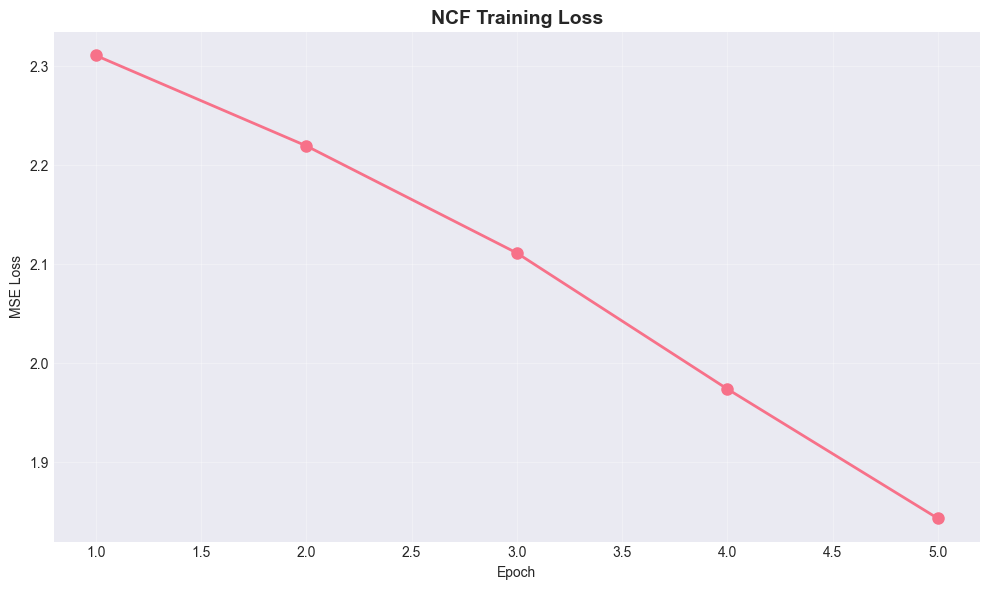

In [15]:
print("(Training for 5 epochs - adjust as needed)")
n_epochs = 5
train_losses = []

for epoch in range(n_epochs):
    ncf_model.train()
    epoch_loss = 0
    
    for batch_idx, (user_ids, item_ids, ratings) in enumerate(train_loader):
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        ratings = ratings.to(device)
        
        # Forward pass
        predictions = ncf_model(user_ids, item_ids)
        loss = criterion(predictions, ratings)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"  Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs+1), train_losses, marker='o', linewidth=2, markersize=8)
plt.title('NCF Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def evaluate_model(model, test_df, model_name, is_ncf=False):
    """
    Evaluate a recommendation model
    """
    print(f"\nEvaluating {model_name}...")
    
    if is_ncf:
        model.eval()
        predictions = []
        actuals = []
        
        with torch.no_grad():
            for _, row in test_df.iterrows():
                user_id = row['reviewerID']
                item_id = row['asin']
                
                if user_id in user_to_idx and item_id in item_to_idx:
                    user_idx = torch.tensor([user_to_idx[user_id]]).to(device)
                    item_idx = torch.tensor([item_to_idx[item_id]]).to(device)
                    pred = model(user_idx, item_idx).cpu().item()
                    predictions.append(pred)
                    actuals.append(row['overall'])
    
    elif model_name == 'Feature-Based Hybrid':
        predictions = model.predict(test_df)
        actuals = test_df['overall'].values
    
    else:
        predictions = []
        actuals = []
        
        for _, row in test_df.head(1000).iterrows():
            try:
                pred = model.predict(row['reviewerID'], row['asin'])
                predictions.append(pred)
                actuals.append(row['overall'])
            except:
                continue
    
    if len(predictions) > 0:
        rmse = math.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  Evaluated on {len(predictions):,} samples")
        
        return {'model': model_name, 'rmse': rmse, 'mae': mae, 'samples': len(predictions)}
    else:
        print(f"  No valid predictions")
        return {'model': model_name, 'rmse': np.nan, 'mae': np.nan, 'samples': 0}

results = []

# Baseline: SVD
results.append(evaluate_model(svd_model, test_df, 'SVD (Baseline)'))

# Hybrid 1: Weighted Ensemble  
results.append(evaluate_model(hybrid_weighted, test_df, 'Weighted Ensemble'))

# Hybrid 2: Feature-Based
results.append(evaluate_model(hybrid_features, test_df, 'Feature-Based Hybrid'))

# Hybrid 3: NCF
results.append(evaluate_model(ncf_model, test_df, 'Neural CF (NCF)', is_ncf=True))

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


Evaluating SVD (Baseline)...
  RMSE: 1.3838
  MAE:  0.9030
  Evaluated on 933 samples

Evaluating Weighted Ensemble...
  RMSE: 1.2832
  MAE:  0.9779
  Evaluated on 933 samples

Evaluating Feature-Based Hybrid...
  RMSE: 0.5817
  MAE:  0.3121
  Evaluated on 933 samples

Evaluating Neural CF (NCF)...
  RMSE: 1.3564
  MAE:  1.2370
  Evaluated on 371 samples
               model   rmse    mae  samples
      SVD (Baseline) 1.3838 0.9030      933
   Weighted Ensemble 1.2832 0.9779      933
Feature-Based Hybrid 0.5817 0.3121      933
     Neural CF (NCF) 1.3564 1.2370      371


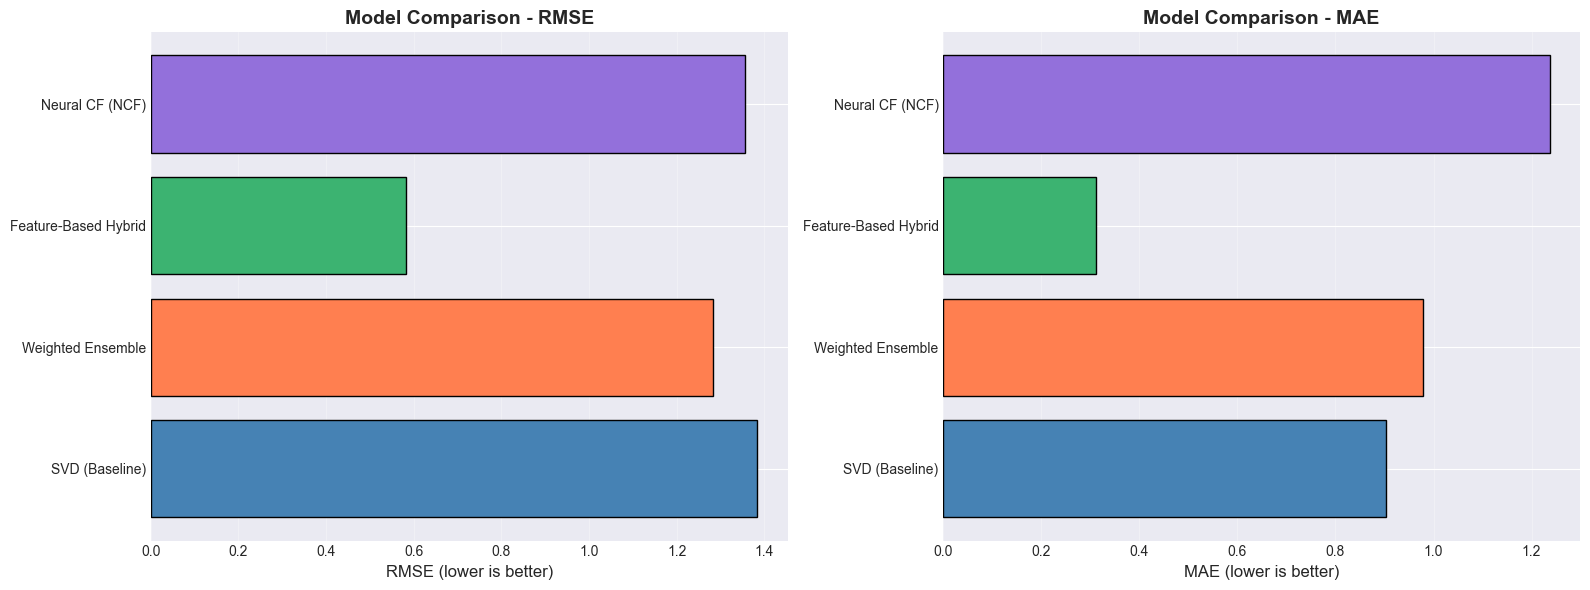

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
colors = ['steelblue', 'coral', 'mediumseagreen', 'mediumpurple']
ax.barh(results_df['model'], results_df['rmse'], color=colors, edgecolor='black')
ax.set_xlabel('RMSE (lower is better)', fontsize=12)
ax.set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

ax = axes[1]
ax.barh(results_df['model'], results_df['mae'], color=colors, edgecolor='black')
ax.set_xlabel('MAE (lower is better)', fontsize=12)
ax.set_title('Model Comparison - MAE', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
os.makedirs('models/hybrid', exist_ok=True)

with open('models/hybrid/weighted_ensemble.pkl', 'wb') as f:
    pickle.dump(hybrid_weighted, f)
print(" Saved: models/hybrid/weighted_ensemble.pkl")

with open('models/hybrid/feature_based.pkl', 'wb') as f:
    pickle.dump(hybrid_features, f)
print(" Saved: models/hybrid/feature_based.pkl")

torch.save({
    'model_state_dict': ncf_model.state_dict(),
    'n_users': n_users,
    'n_items': n_items,
    'user_to_idx': user_to_idx,
    'item_to_idx': item_to_idx
}, 'models/hybrid/ncf_model.pt')
print(" Saved: models/hybrid/ncf_model.pt")

results_df.to_csv('outputs/week4_evaluation_results.csv', index=False)
print(" Saved: outputs/week4_evaluation_results.csv")

 Saved: models/hybrid/weighted_ensemble.pkl
 Saved: models/hybrid/feature_based.pkl
 Saved: models/hybrid/ncf_model.pt
 Saved: outputs/week4_evaluation_results.csv
